(f_rs_ml_predict)=

---------------
```{admonition} Learning Objectives
  - Fit and predict machine learning models to make spatial predictions
    - Use sklearn pipelines, cross-validation and hyper parameter tuning for spatial data
  - Predict landcover or continuous models 
  - Make predictions using timeseries data

```
```{admonition} Review
* [Geowombat IO](f_rs_io.md)
* [Geowombat Extraction](f_rs_extraction.md)
* [Sklearn_xarray](https://phausamann.github.io/sklearn-xarray/)
* [Sklearn pipelines](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf)
```
--------------


# Spatial Prediction using ML in Python
## Create Land Use Classification using Geowombat & Sklearn

The most common task for remotely sensed data is creating land cover classification. In this tutorial we will walk you through how to train a ML model using raster data. These methods are heavily dependent on the great package [sklearn_xarray](https://phausamann.github.io/sklearn-xarray/). To understand the pipeline commands please see their [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [examples](https://scikit-learn.org/stable/auto_examples/index.html#pipelines-and-composite-estimators). 

### Supervised Classification in Python
In the following example we will use Landsat data, some training data to train a supervised sklearn model. In order to do this we first need  to have land classifications for a set of points of polygons. In this case we have three polygons with the classes ['water','crop','tree','developed']. The first step is to use `LabelEncoder` to convert these to integer based categories, which we store in a new column called 'lc'.

In [1]:
import geowombat as gw
from geowombat.data import l8_224078_20200518, l8_224078_20200518_polygons
from geowombat.ml import fit, predict, fit_predict
import geopandas as gpd
from sklearn_xarray.preprocessing import Featurizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

le = LabelEncoder()

# The labels are string names, so here we convert them to integers
labels = gpd.read_file(l8_224078_20200518_polygons)
labels['lc'] = le.fit(labels.name).transform(labels.name)
print(labels)

/home/mmann1123/miniconda3/envs/pygis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        name                                           geometry  lc
0      water  POLYGON ((737544.502 -2795232.772, 737544.502 ...   3
1       crop  POLYGON ((742517.658 -2798160.232, 743046.717 ...   0
2       tree  POLYGON ((742435.36 -2801875.403, 742458.874 -...   2
3  developed  POLYGON ((738903.667 -2811573.845, 738926.586 ...   1


We are then going to generate our sklearn pipeline ([see simple tutorial here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf)). A pipeline simply allows us to pass a numpy array through a defined set of operations. In this case the data is passed through the following operations:

 * `StandardScaler`: [Normalizes](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) all variables by removing the mean and scaling to unit variance
 * `PCA`: Calculates [Principal Components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) to reduce dimensionality. 
 * `GaussianNB`: Fits a [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html?highlight=gaussiannb#sklearn.naive_bayes.GaussianNB) model for a quick classification. 

 In this example we will fit and predict the model in two steps. The `fit` method returns three objects, a transformed version of the original dataset `X` that can be used by sklearn, `Xy` a tuple containing the data used for training `(X,y)` where any data outside the polygons is removed, and the trained pipeline `clf` object.

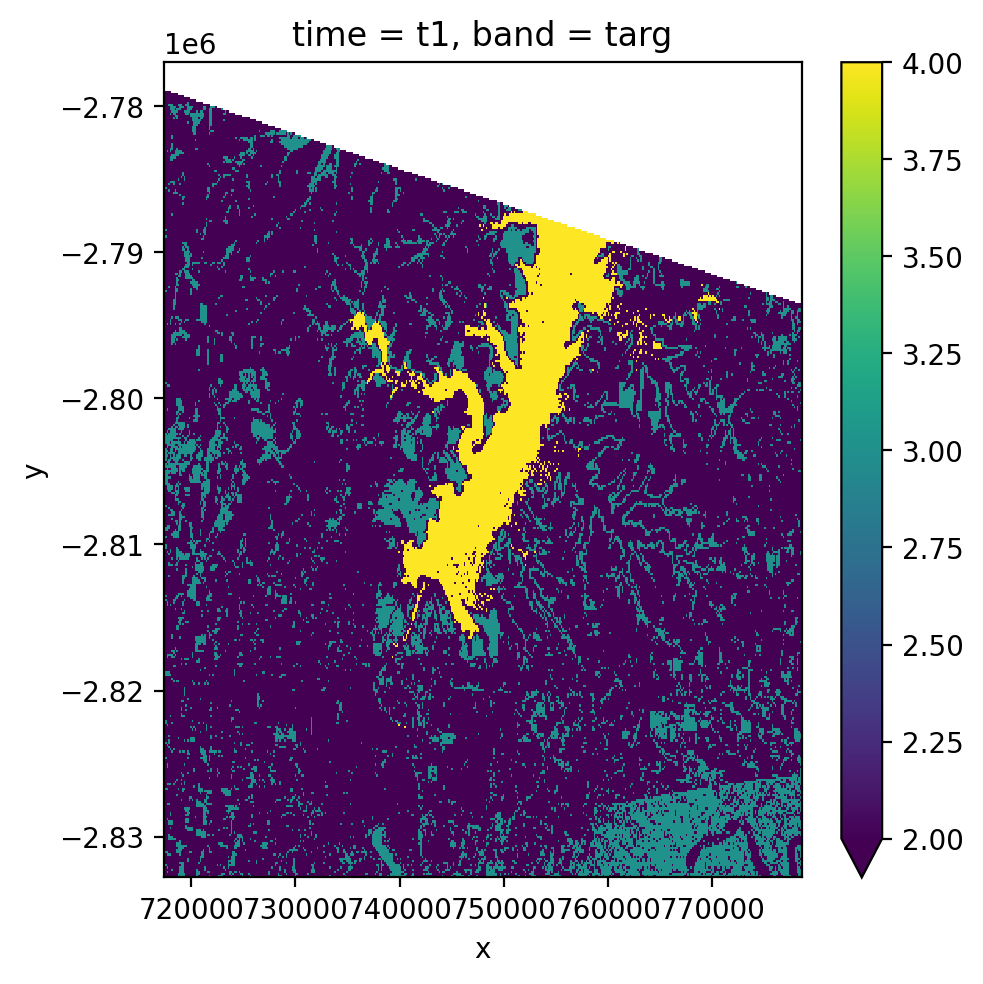

In [2]:
import matplotlib.pyplot as plt

# Use a data pipeline
pl = Pipeline([ ('scaler', StandardScaler()),
                ('pca', PCA()),
                ('clf', GaussianNB())])

fig, ax = plt.subplots(dpi=200,figsize=(5,5))

# Fit the classifier
with gw.config.update(ref_res=150):
    with gw.open(l8_224078_20200518, nodata=0) as src:
        X, Xy, clf = fit(src, pl, labels, col="lc")
        y = predict(src, X, clf)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

In order to fit and predict to our original data in one step, we simply use `fit_predict`:

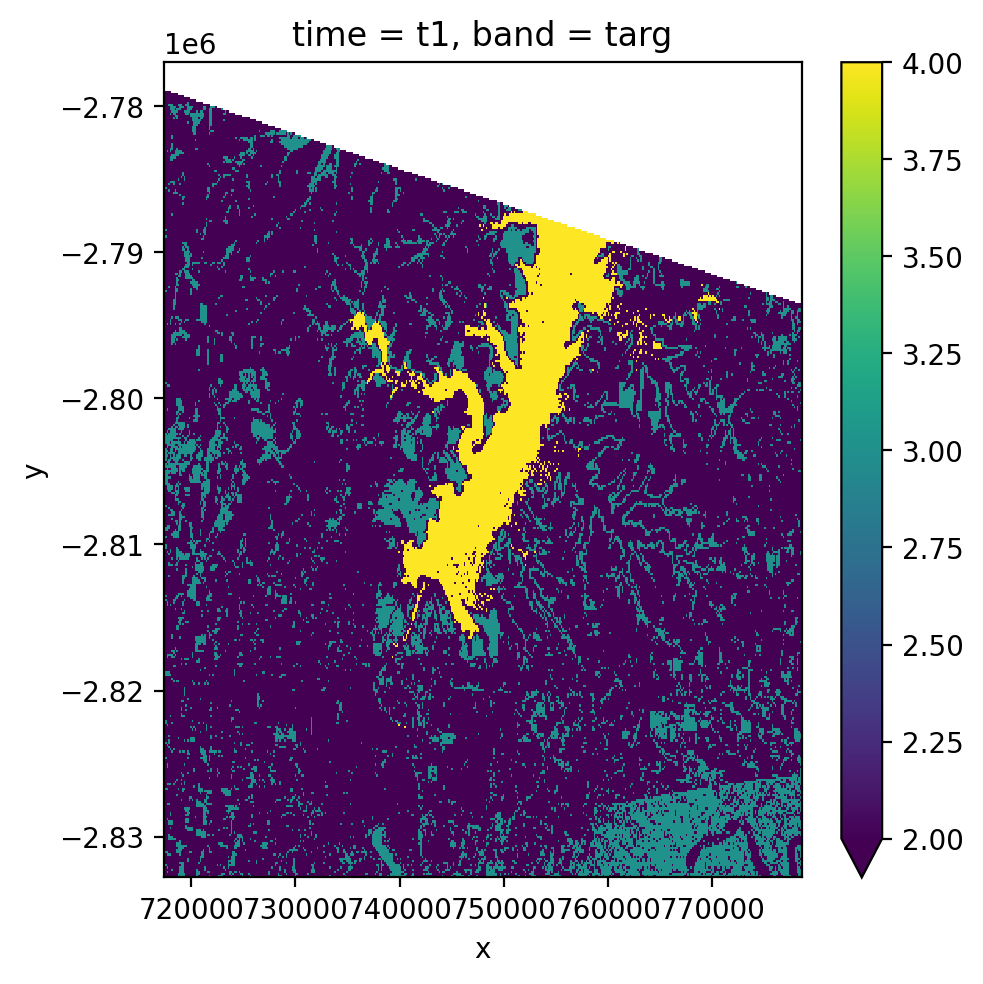

In [3]:
from geowombat.ml import fit_predict
fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=150):
    with gw.open(l8_224078_20200518, nodata=0) as src:
        y = fit_predict(src, pl, labels, col='lc')
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)


### Unsupervised Classification in Python
Unsupervised classification takes a different approach. Here we don't have to provide examples of different land cover types. Instead we rely on the algorithm to identify distinct clusters of similar data, and apply a unique label to each cluster. For instance, if we are talking about land cover water and trees are going to look very different. Water reflects more blue and absorbs all the near infrared, while trees reflect little blue and reflect lots of near infrared.  Therefore water and trees should 'cluster' together when plotted out according to their different blue and near infrared reflectances. These clusters will be assigned a unique value to each pixel, e.g. water will be assigned 1 and trees 2. Later, the end user will need to go back and assign the label to each numbered cluster, e.g. water=1, trees=2.

In this example we will use [kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) to do our clustering. To run we need to decide apriori how many clusters we want to identify. Typically you want to roughly double the number of expected classes and then recombine them later into the desired labels. This helps to better understand and categorize the variation in your image.

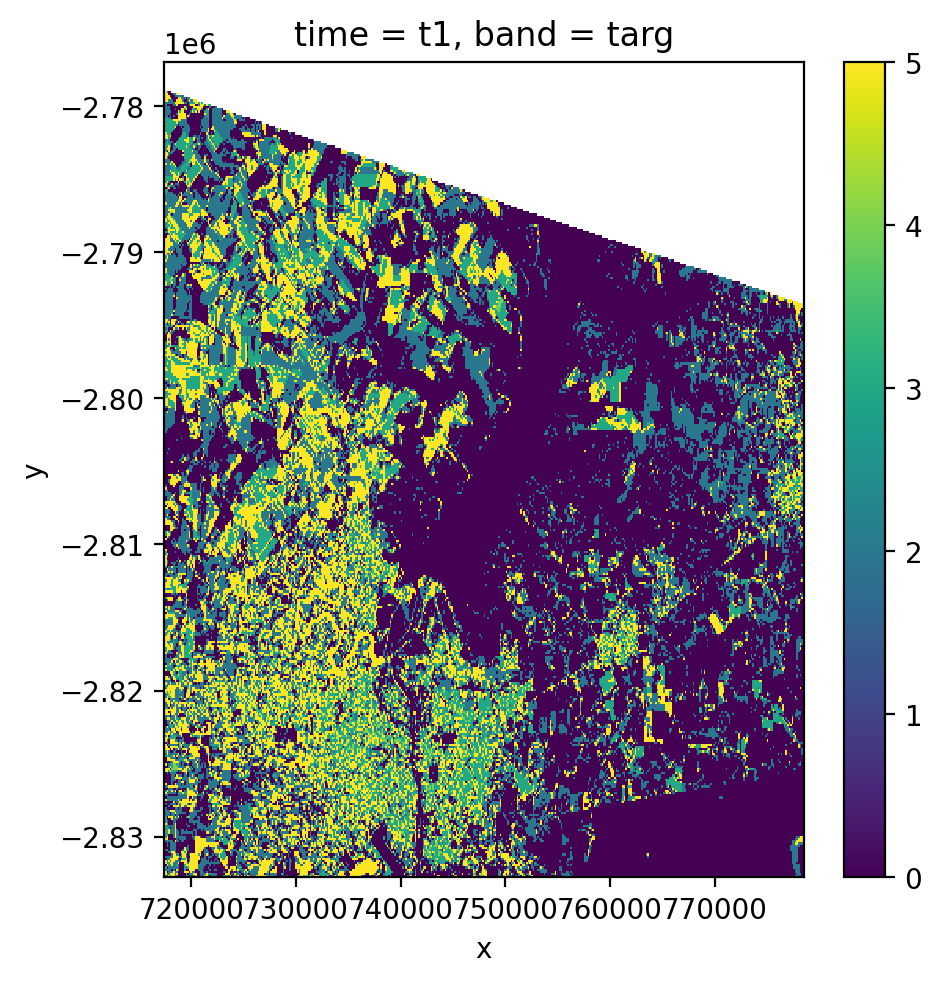

In [4]:
from sklearn.cluster import KMeans
cl = Pipeline([ ('clf', KMeans(n_clusters=6, random_state=0))])

fig, ax = plt.subplots(dpi=200,figsize=(5,5))

# Fit_predict unsupervised classifier
with gw.config.update(ref_res=150):
    with gw.open(l8_224078_20200518, nodata=0) as src:
        y= fit_predict(src, cl)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

In this case we can see that it effective labels different clusters of data, and now it is up to us to determine which clusters should be categorized as water, trees, and fields etc. 

## Spatial prediction with time series stack using Geowombat & Sklearn

If you have a stack of time series data it is simple to apply the same method as we described previously, except we need to open multiple images, set `stack_dim` to 'time' and set the `time_names`.  *Note* we are just pretending we have two dates of LandSat imagery here.

<xarray.DataArray (band: 1, y: 372, x: 408)> Size: 1MB
dask.array<xarray-<this-array>, shape=(1, 372, 408), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 3kB 7.174e+05 7.176e+05 ... 7.783e+05 7.785e+05
  * y        (y) float64 3kB -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
    time     <U2 8B 't1'
    targ     (y, x) uint8 152kB dask.array<chunksize=(256, 256), meta=np.ndarray>
  * band     (band) <U4 16B 'targ'
Attributes: (12/13)
    transform:           (150.0, 0.0, 717345.0, 0.0, -150.0, -2776995.0)
    crs:                 32621
    res:                 (150.0, 150.0)
    is_tiled:            0
    nodatavals:          (0, 0, 0)
    _FillValue:          0
    ...                  ...
    offsets:             (0.0, 0.0, 0.0)
    filename:            ['LC08_L1TP_224078_20200518_20200518_01_RT.TIF', 'LC...
    resampling:          nearest
    AREA_OR_POINT:       Area
    _data_are_separate:  1
    _data_are_stacked:   1


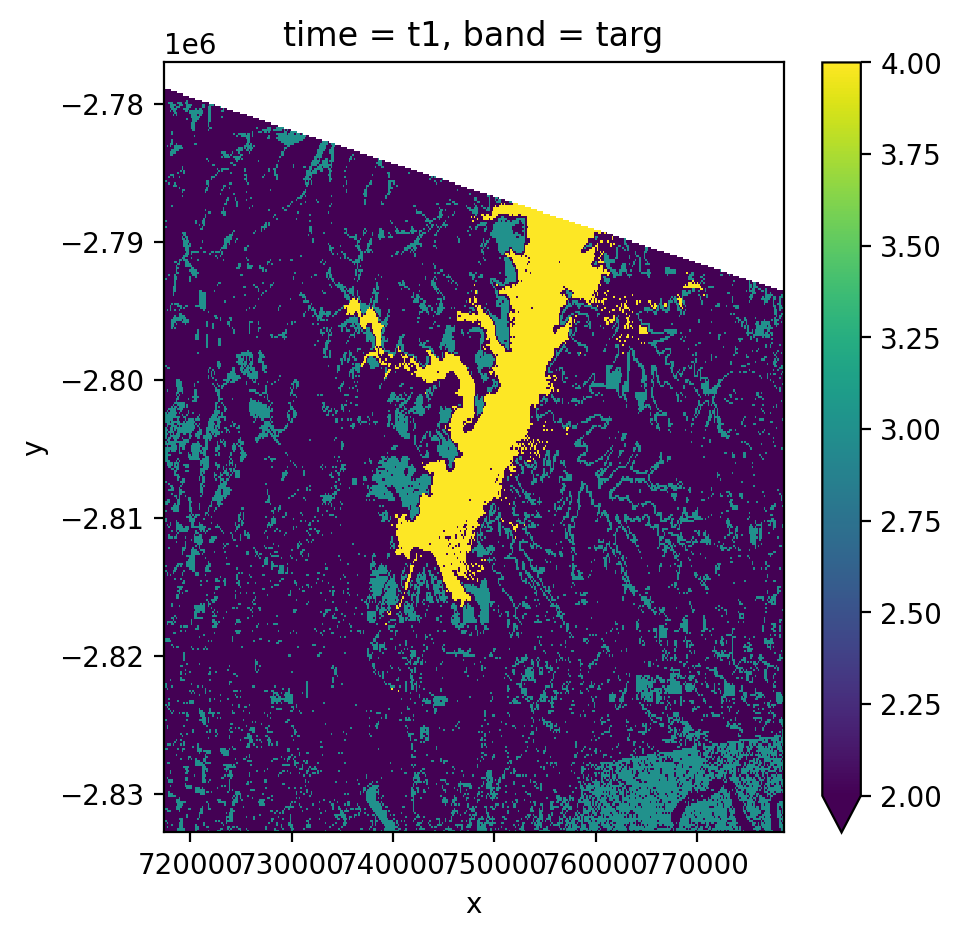

In [5]:
fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=150):
   with gw.open([l8_224078_20200518, l8_224078_20200518], 
                stack_dim='band', 
                nodata=0) as src:
        y = fit_predict(src, pl, labels, col='lc')
        print(y)
        y.plot(robust=True, ax=ax)

If you want to do more sophisticated model tuning using sklearn it is also possible to break up your fit and predict steps as follows:

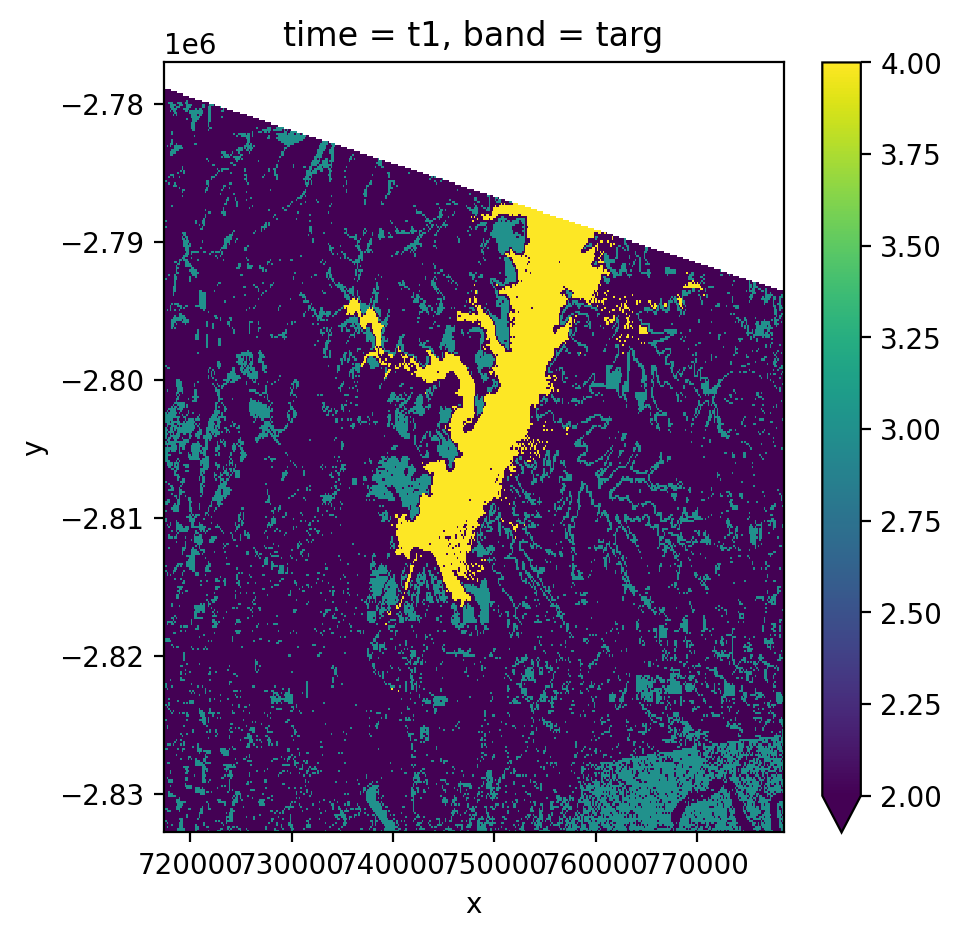

In [6]:
fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=150):
    with gw.open(l8_224078_20200518, nodata=0) as src:
        X, Xy, clf = fit(src, pl, labels, col="lc")
        y = predict(src, X, clf)
        y.plot(robust=True, ax=ax)

## Cross-validation and Hyperparameter Tuning with Spatial Prediction
One of the most important parts of successfully building a model is a careful assessment of model performance. To do this we will leverage some of `sklearn` built in tools. One of the most common cross-validation methods is called k-fold, where you data is broken in to independent sets of training and testing data multiple times. The ability of the model - trained on the 'training' data - to predict the outcome of the 'testing' data multiple times. We can then have a measure of how well our model will work on data it has never seen before. 

In this case we are going to use our supervised classification pipeline `pl` from earlier. And we will use [kfold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold) to do [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html). To use `kfold` with `geowombat` we need to use `CrossValidatorWrapper` as seen in the example below to allow it to work with `xarray` objects. 

We often also need to [hyper-parameter tune](https://scikit-learn.org/stable/modules/grid_search.html)
our model. In this case we will see if we need to keep 1, 2, or 3 [pca](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) components. We might also want to experiment with whether scaling the data range impacts our perforamnce with [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standardscaler#sklearn.preprocessing.StandardScaler) by changing whether or not variables are divided by their standard deviation. 

To do hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) in a pipeline we need to set up the 'parameter-grid'. This part can be a little confusing. To help us let's isolate the `Pipeline` and `param_grid` from the example below:

``` python
pl = Pipeline([('scaler', StandardScaler()),
               ('pca', PCA()),
               ('clf', GaussianNB())])

param_grid={"scaler__with_std":[True,False],
            "pca__n_components": [1, 2, 3]
            }
```
Notice that each step in the pipeline is labeled (e.g. 'scaler', 'pca', 'clf'). To try out different parameters for each step we are going to need to reference them by name in our `param_grid` dictionary. The dictionary follows this convention:

`(step_name)__(parameter_name):[value_1, value2]`

So `"pca__n_components": [1, 2, 3]` says that for the `pca` step of the pipeline, we will try out tree different values for the parameter `n_components`, allowing us to choose the one that performs best at predicting our 'testing' data.

{'mean_fit_time': array([0.02978282, 0.03216944, 0.03088088, 0.04051414, 0.0339602 ,
       0.03285961]), 'std_fit_time': array([0.01268907, 0.01220501, 0.01280433, 0.01645652, 0.01686904,
       0.00911179]), 'mean_score_time': array([0.0199842 , 0.0272943 , 0.01923423, 0.02078547, 0.02181134,
       0.01547008]), 'std_score_time': array([0.00603066, 0.00889152, 0.00505685, 0.00850104, 0.00808258,
       0.00227719]), 'param_pca__n_components': masked_array(data=[1, 1, 2, 2, 3, 3],
             mask=[False, False, False, False, False, False],
       fill_value=999999), 'param_scaler__with_std': masked_array(data=[True, False, True, False, True, False],
             mask=[False, False, False, False, False, False],
       fill_value=True), 'params': [{'pca__n_components': 1, 'scaler__with_std': True}, {'pca__n_components': 1, 'scaler__with_std': False}, {'pca__n_components': 2, 'scaler__with_std': True}, {'pca__n_components': 2, 'scaler__with_std': False}, {'pca__n_components': 3, 'scal

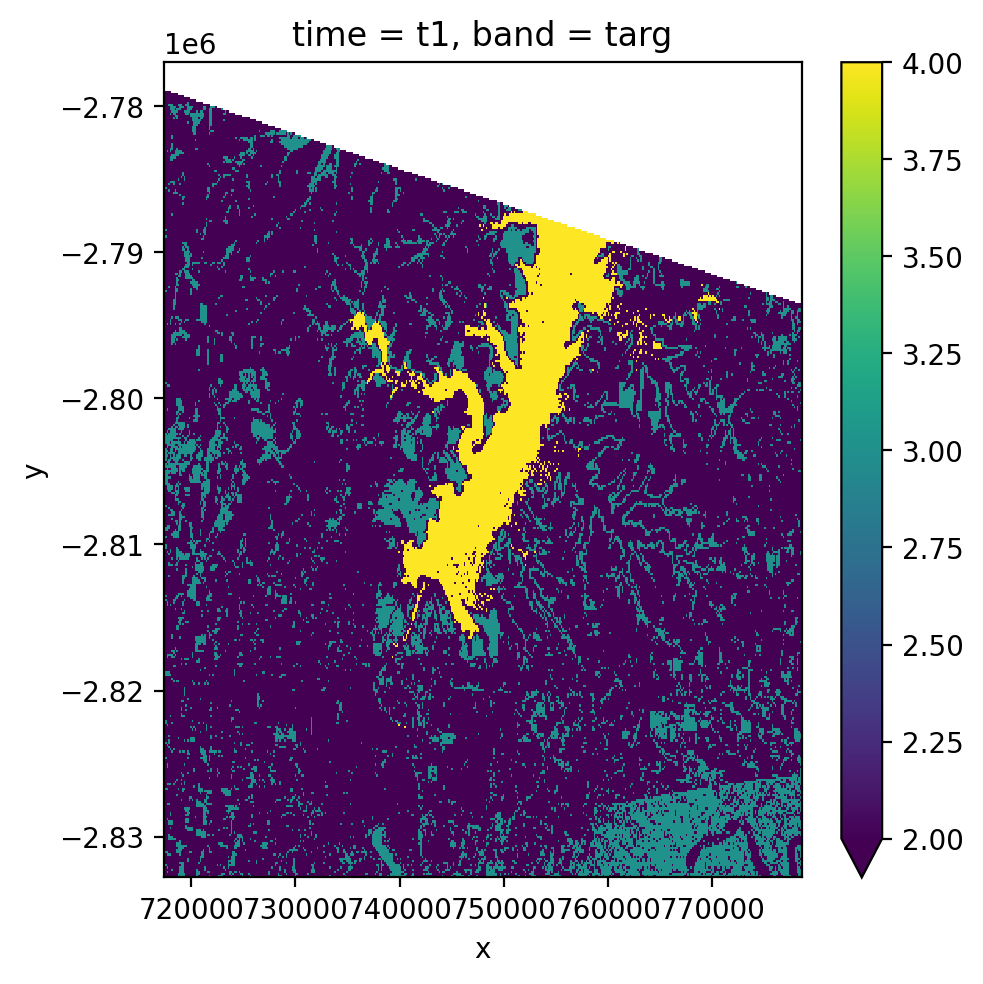

In [7]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn_xarray.model_selection import CrossValidatorWrapper

pl = Pipeline([('scaler', StandardScaler()),
               ('pca', PCA()),
               ('clf', GaussianNB())])

cv = CrossValidatorWrapper(KFold())
gridsearch = GridSearchCV(pl, cv=cv, scoring='balanced_accuracy',
                    param_grid={
                      "scaler__with_std":[True,False],
                      "pca__n_components": [1, 2, 3]
                      })

fig, ax = plt.subplots(dpi=200,figsize=(5,5))

with gw.config.update(ref_res=150):
    with gw.open(l8_224078_20200518, nodata=0) as src:
        # fit a model to get Xy used to train model
        X, Xy, pipe = fit(src, pl, labels, col="lc")

        # fit cross valiation and parameter tuning
        # NOTE: must unpack * object Xy
        gridsearch.fit(*Xy)
        print(gridsearch.cv_results_)
        print(gridsearch.best_score_)
        print(gridsearch.best_params_)        

        # get set tuned parameters and make the prediction
        # Note: predict(gridsearch.best_model_) not currently supported
        pipe.set_params(**gridsearch.best_params_)
        y = predict(src, X, pipe)
        y.plot(robust=True, ax=ax)
plt.tight_layout(pad=1)

In order to create a model with the optimal parameters we need to use `gridsearch.best_params_`, which holds a dictionary of each parameter and its optimal value. To 'use' these values we need to update the parameters held in our returned pipeline, `pipe`, by using the `.set_params` method. We use `**` to unpack the dictionary values, tutorial on [unpacking here](https://medium.com/ml-and-automation/how-to-unpack-list-dictionary-tuple-in-python-c0705d29931c).

Notice that the `gridsearch` has a few attributes of interest. This includes all the results of the kfold rounds `.cv_results_`, the best score obtained `.best_score_`, and the ideal set of parameters to use in the pipeline `.best_params_`.  This lase one `.best_params_` will be use to update our `pipe` pipeline for prediction. 

## Handling Missing Data

Missing data can be a real problem when working with remote sensing data. In the case of Landsat data, missing data is often represented by a value of 0. Or perhaps you already have masked missing data values as `np.nan`. 

This can be a problem when using sklearn models *that expect all data to be present*. To handle this we can use the `nodata` value in `gewombat.open()` and `SimpleImputer` from sklearn in our pipeline. 

If we had a dataset that had 0s as missing data we could use the following to mask out 0s and replace with `np.nan`, then we can pass that data to our pipeline, that replaces `np.nan` with the mean of the column. 

``` python
from sklearn.impute import SimpleImputer

classifier = Pipeline(
    [
        ("remove_nan", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("clf", KMeans(n_clusters=6, random_state=0)),
    ]
)

with gw.open(files, 
             band_names=[band_name],
             time_names = dates,nodata=-9999  ) as ds:
    ds = ds.gw.mask_nodata()
    y = fit_predict(ds, classifier)
```
Other sklearn imputers are available, see [here](https://scikit-learn.org/stable/modules/impute.html) for more information.